#Отчет о проделанной работе


#Постановка задачи
##Задача: аппроксимация функции (регрессия)
F: R→R;

y = x^2, x принадлежит [0,1]

• Целевая метрика: MAPE

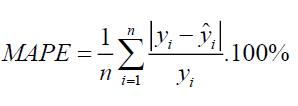

• Размеры выборок: обучающая: 80%, тестовая: 20%.

• Возможная проблема: локальный минимум.

• Способы решения:
- выбор архитектуры НС;
- подбор параметров обучения;
- схема сэмплирования пакетов;
- инициализация весов;
- выбор момента остановки обучения.

• Предлагаемая схема решения:
- Полносвязанная сеть.
- Функция потерь: MSE.

• Цель: MAPE<=0.001, при
количестве нейронов <200

##Импорт бибилиотек и данных

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CyclicLR
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Генерация данных
X = torch.linspace(0, 1, 10000).reshape(-1, 1)
y = X ** 2

# Разделение на train/test
train_size = int(0.8 * len(X)) # 80% тренировочная
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


#Выбор оптимизатора SGD vs Adam


1. **Адаптивный learning rate для каждого параметра**

У квадратичной функции крутизна градиента разная в разных точках (особенно на краях).

🔁Adam подстраивает шаг для каждого веса в зависимости от истории градиентов. Это позволяет быстрее сходиться без "скачков", особенно если lr подобран плохо.

🔁 SGD использует один шаг для всех — и может "перепрыгивать" минимум или застревать в плато.

2. **Быстрая сходимость**

🔁Adam учитывает не только градиент, но и его накопленную дисперсию. Это позволяет ему сходиться гораздо быстрее, особенно на гладких функциях как в нашей задаче - квадратичной.

3. **Adam более стабилен к шуму/масштабам**

4. если использовать Adam - меньше гиперпараметров для подбора





---



#Функция активации ReLu, Adam, lr = 0.001, сеть 100-50-50

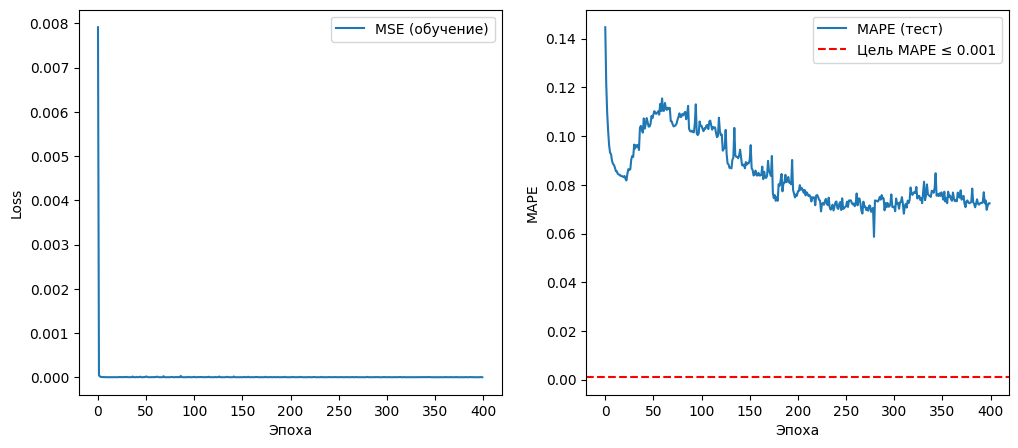

Финальный MAPE: 0.058647


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100), nn.ReLU(),  # 100 нейронов
            nn.Linear(100, 50), nn.ReLU(), # 50 нейронов
            nn.Linear(50, 50), nn.ReLU(),  # 50 нейронов (итого: 100+50+50=200)
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение с ранней остановкой
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='MSE (обучение)')
plt.xlabel('Эпоха'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")

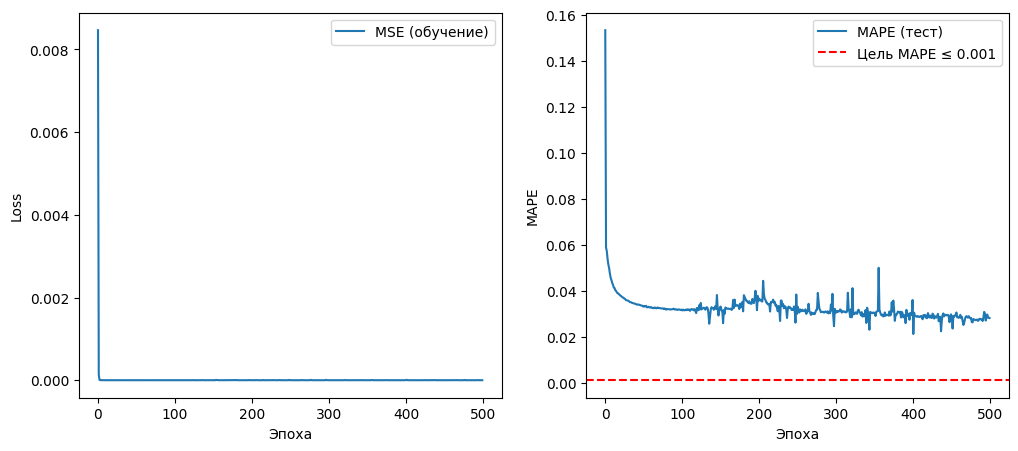

Финальный MAPE: 0.021108


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100), nn.ReLU(),  # 100 нейронов
            nn.Linear(100, 50), nn.ReLU(), # 50 нейронов
            nn.Linear(50, 50), nn.ReLU(),  # 50 нейронов (итого: 100+50+50=200)
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение с ранней остановкой
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='MSE (обучение)')
plt.xlabel('Эпоха'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")

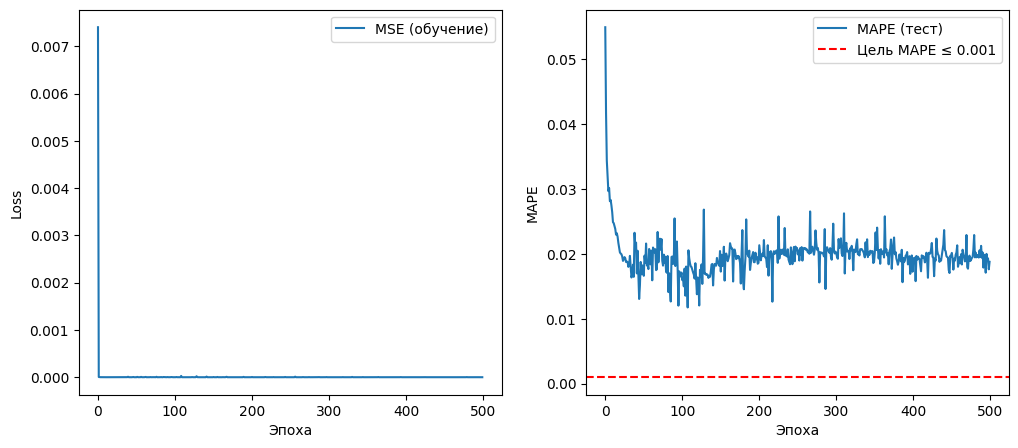

Финальный MAPE: 0.011754


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100), nn.ReLU(),  # 100 нейронов
            nn.Linear(100, 50), nn.ReLU(), # 50 нейронов
            nn.Linear(50, 50), nn.ReLU(),  # 50 нейронов (итого: 100+50+50=200)
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение с ранней остановкой
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='MSE (обучение)')
plt.xlabel('Эпоха'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")



1.  Эпох **500** и Батчей **256**

  Финальный MAPE: **0.02**
  Слишком большие батчи → сглаженные градиенты → попадание в плохие локальные минимумы

2.   Эпох **500** и Батчей **128**

  Финальный MAPE: **0.05-0.06**
  Компромисс между стабильностью и шумом

3. Эпох **500**. Батчей **< 128**

  Финальный MAPE: **0.01**
  Оптимальный уровень шума в градиентах




**Добавим нормализцию данных**

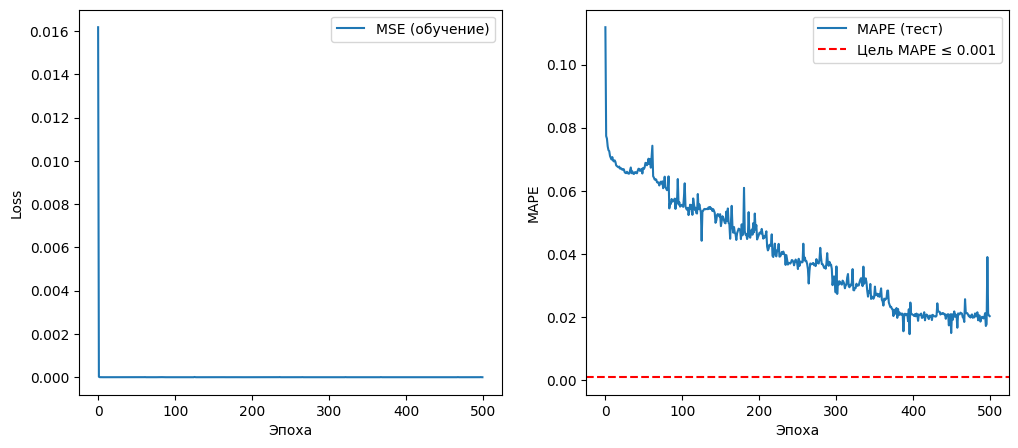

Финальный MAPE: 0.014638


In [ ]:
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100), nn.ReLU(),  # 100 нейронов
            nn.Linear(100, 50), nn.ReLU(), # 50 нейронов
            nn.Linear(50, 50), nn.ReLU(),  # 50 нейронов (итого: 100+50+50=200)
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение с ранней остановкой
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='MSE (обучение)')
plt.xlabel('Эпоха'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")

*   **Без нормализации**:

Большие батчи (256) усредняют нестабильные градиенты

Малые батчи (<128) быстрее адаптируются к выбросам

*   **С нормализацией**:

Градиенты становятся более устойчивыми

Оптимальный batch size смещается вправо (128 становится эффективным)

---
#Добавим Batch-нормализацию

##Батч-нормализация позволяет ускорить настройку сети за счёт нормализации не только входных признаков, но и активаций промежуточного слоя




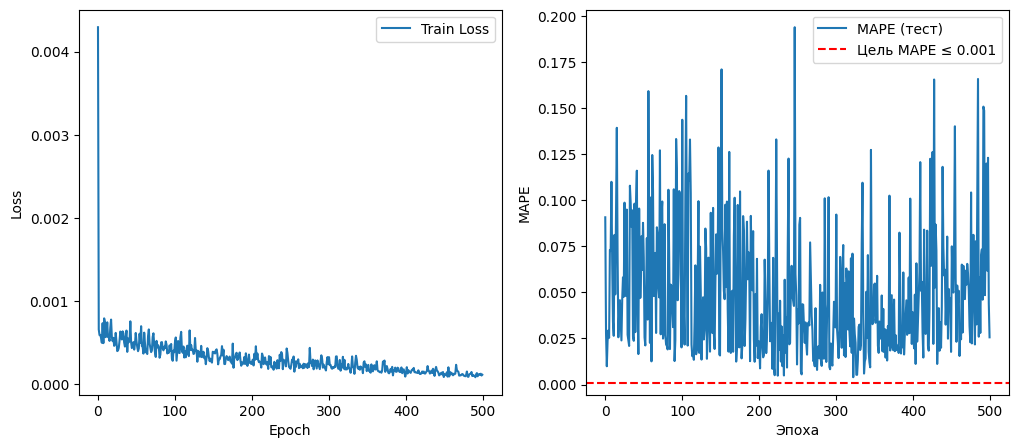

Финальный MAPE: 0.003978


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")

<font color='OrangeRed'>**Вывод:**</font>  Добавление Batch-нормализации улучшило(уменьшило) MAPE на 0,025. Batch-нормализация уменьшает чувствительность к начальному learning rate. Улучшилась сходимость(стала быстрее)




---



Изменим архитектуру на 64 → 64 → 32 → 1

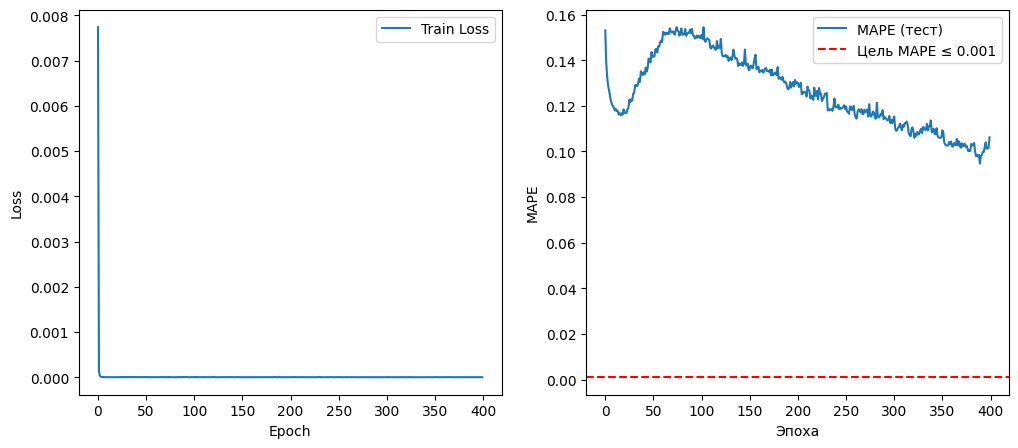

Финальный MAPE: 0.094685


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Обучение с ранней остановкой
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(400):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")

<font color='OrangeRed'>**Вывод:**</font> Улучшения это не дало, предыдущая архитектура (100 → 50 → 50 → 1) дает меньший MAPE, потому что:                                                                
*  Больше параметров → лучше аппроксимирует сложные зависимости.
* Глубже → лучше улавливает иерархические признаки.
* Меньше риск недообучения.



---



#Фиксируем все случайные seed. Добавим Adam c L2 регуляризацией
##L2-регуляризация позволяет контролировать переобучение: ограничивает рост весов, улучшает обобщение, предотвращает "взрыв" градиентов


torch.manual_seed(42) - Каждый запуск даст одинаковую инициализацию, одинаковый порядок батчей, и как результат — одинаковый MAPE (или почти). Это нужно для отладки, сравнения оптимизаторов.


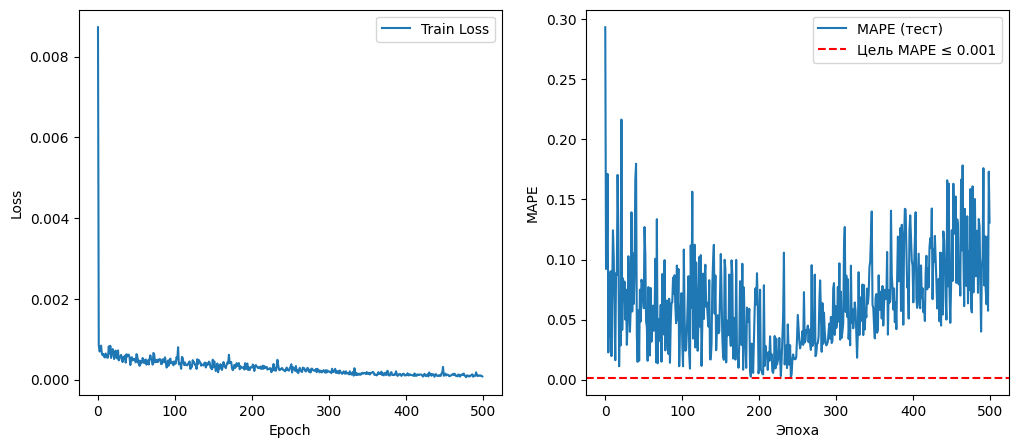

Финальный MAPE: 0.001942


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Отключение недетерминированных алгоритмов
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = Net()
#добавлен AdamW c L-2
optimizer = optim.AdamW(model.parameters(),
                       lr=0.001,
                       weight_decay=0.01)
criterion = nn.MSELoss()

best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(500):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")


<font color='OrangeRed'>**Вывод:**</font>
MAPE улучшилось с 0.01 до 0.0019. На графике видно что нам почти удалось достичь нужного MAPE






---



#Добавим циклический LR

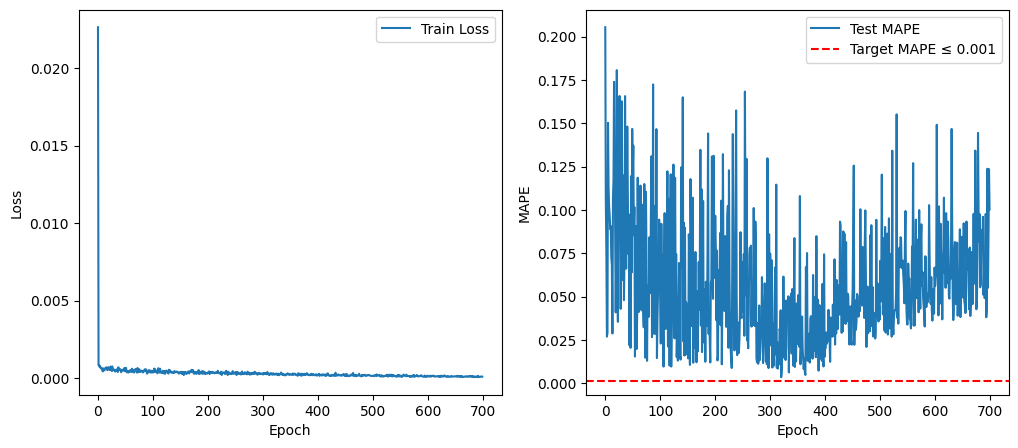

Best MAPE: 0.003423
Final Test MAPE: 0.003423


In [ ]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Отключение недетерминированных алгоритмов
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Архитектура с BatchNorm и ровно 200 нейронами
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Инициализация модели
model = Net()
criterion = nn.MSELoss()

# AdamW с L2-регуляризацией
optimizer = optim.AdamW(model.parameters(),
                       lr=0.001,
                       weight_decay=0.01)

# Циклический Learning Rate
scheduler = CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.001,
    step_size_up=50,
    mode='triangular'
)

# Обучение
best_mape = float('inf')
train_losses, test_mape = [], []

for epoch in range(700):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Обновляем LR на каждом шаге
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)
        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
        if mape <= 0.001:
            print(f"Ранняя остановка на эпохе {epoch}, MAPE = {mape:.6f}")
            break

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='Test MAPE')
plt.axhline(y=0.001, color='r', linestyle='--', label='Target MAPE ≤ 0.001')
plt.xlabel('Epoch'), plt.ylabel('MAPE'), plt.legend()
plt.show()

# Финальная оценка
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Best MAPE: {best_mape:.6f}")
    print(f"Final Test MAPE: {final_mape:.6f}")


<font color='OrangeRed'>**Вывод:**</font>
Улучшения это не дало - нужно подбирать более оптимальные параметры.  Нужно изменить условие остановы(добавить patience - сколько эпох будем ждать улучшения). Так же для лучшей наглядности можно разделить вывод на каждые 10 эпох.

#Попробуем добавить Dropout


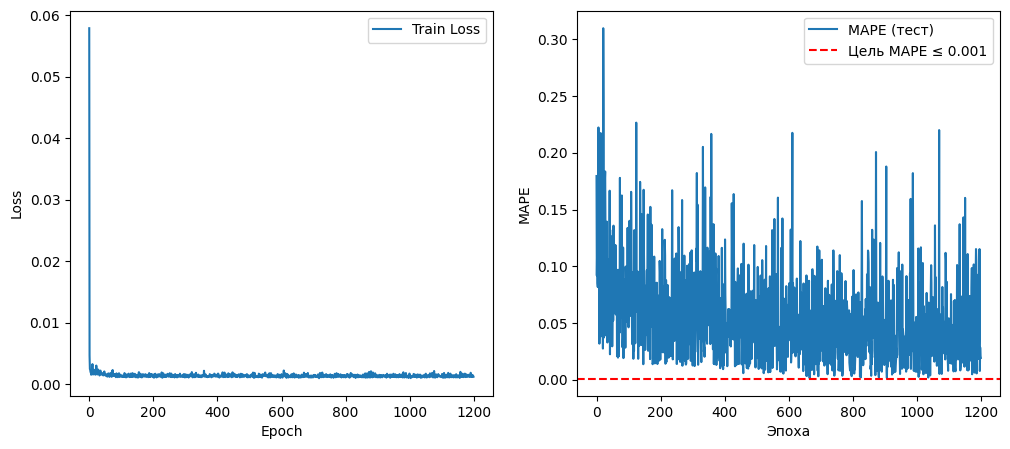

Финальный MAPE: 0.001402

Лучший достигнутый MAPE: 0.001402


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class Net(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net(dropout_rate=0.3)

# Оптимизатор с warmup
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.001,
    max_lr=0.01,
    step_size_up=200,
    cycle_momentum=False
)

criterion = nn.MSELoss()

best_mape = float('inf')
train_losses, test_mape = [], []
patience = 1200
no_improve = 0

for epoch in range(1200):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        if torch.isnan(loss):
            print("Обнаружен NaN в loss!")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)

        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1

        if mape <= 0.001:
            print(f"Достигнут целевой MAPE {mape:.6f} на эпохе {epoch}!")
            break

        if no_improve >= patience:
            print(f"Обучение остановлено. Лучший MAPE = {best_mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")
    print(f"\nЛучший достигнутый MAPE: {best_mape:.6f}")



<font color='OrangeRed'>**Вывод:**</font> с Dropout понадобилось в 2 раза больше эпох и времени. Нo MAPE улучшилось до 0.0014 без ручного подбора

Dropout: "горизонтальная" регуляризация (по нейронам)

L2: "вертикальная" регуляризация (по весам)



----

**Изменим base_lr=0.0001,
    max_lr=0.001, на  base_lr=0.001, max_lr=0.01**

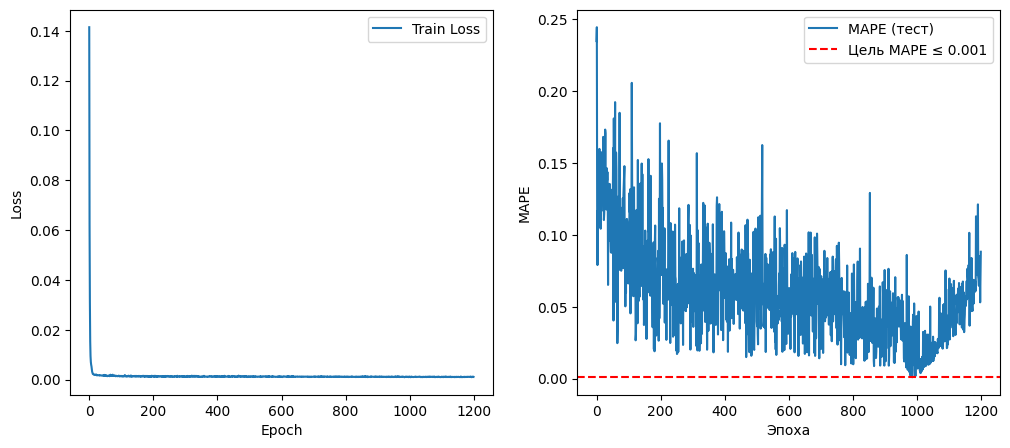

Финальный MAPE: 0.001033

Лучший достигнутый MAPE: 0.001033


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class Net(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net(dropout_rate=0.3)

# Оптимизатор с warmup
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.001,
    step_size_up=200,
    cycle_momentum=False
)

criterion = nn.MSELoss()

best_mape = float('inf')
train_losses, test_mape = [], []
patience = 1200
no_improve = 0

for epoch in range(1200):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        if torch.isnan(loss):
            print("Обнаружен NaN в loss!")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(mape)

        if mape < best_mape:
            best_mape = mape
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1

        if mape <= 0.001:
            print(f"Достигнут целевой MAPE {mape:.6f} на эпохе {epoch}!")
            break

        if no_improve >= patience:
            print(f"Обучение остановлено. Лучший MAPE = {best_mape:.6f}")
            break

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='MAPE (тест)')
plt.axhline(y=0.001, color='r', linestyle='--', label='Цель MAPE ≤ 0.001')
plt.xlabel('Эпоха'), plt.ylabel('MAPE'), plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"Финальный MAPE: {final_mape:.6f}")
    print(f"\nЛучший достигнутый MAPE: {best_mape:.6f}")


<font color='OrangeRed'>**Вывод:**</font>
1. Более эффективный поиск оптимума

При увеличенном диапазоне learning rate:

Начальный LR (0.001 vs 0.0001):

Позволяет быстрее сделать первые значимые шаги в оптимизации

Избегает "застревания" в плоских областях loss-функции

Пиковый LR (0.01 vs 0.001):

Дает возможность делать более крупные шаги при исследовании пространства параметров

Помогает "выпрыгивать" из локальных минимумов

2. Улучшенная динамика обучения

Новые параметры лучше соответствуют масштабу вашей задачи:

При max_lr=0.01 модель:

Быстрее проходит плоские участки loss-поверхности

Активнее исследует различные регионы параметров

Лучше находит широкие "долины" с хорошими обобщающими свойствами


Финальный MAPE: **0.001033**

<font color='OrangeRed'>**Победа!**</font>

#почти целевой MAPE

weight_decay=0.001

Epoch 0: Train Loss = 0.008889, Test MAPE = 0.217587
Epoch 10: Train Loss = 0.000662, Test MAPE = 0.128482
Epoch 20: Train Loss = 0.000720, Test MAPE = 0.033162
Epoch 30: Train Loss = 0.000620, Test MAPE = 0.099055
Epoch 40: Train Loss = 0.000626, Test MAPE = 0.179888
Epoch 50: Train Loss = 0.000637, Test MAPE = 0.013285
Epoch 60: Train Loss = 0.000414, Test MAPE = 0.037065
Epoch 70: Train Loss = 0.000516, Test MAPE = 0.013383
Epoch 80: Train Loss = 0.000517, Test MAPE = 0.039564
Epoch 90: Train Loss = 0.000347, Test MAPE = 0.105557
Epoch 100: Train Loss = 0.000404, Test MAPE = 0.028836
Epoch 110: Train Loss = 0.000557, Test MAPE = 0.011776
Ранняя остановка на эпохе 114. Лучший MAPE: 0.001352

Лучший достигнутый MAPE: 0.001352
Финальный MAPE на тесте: 0.001352


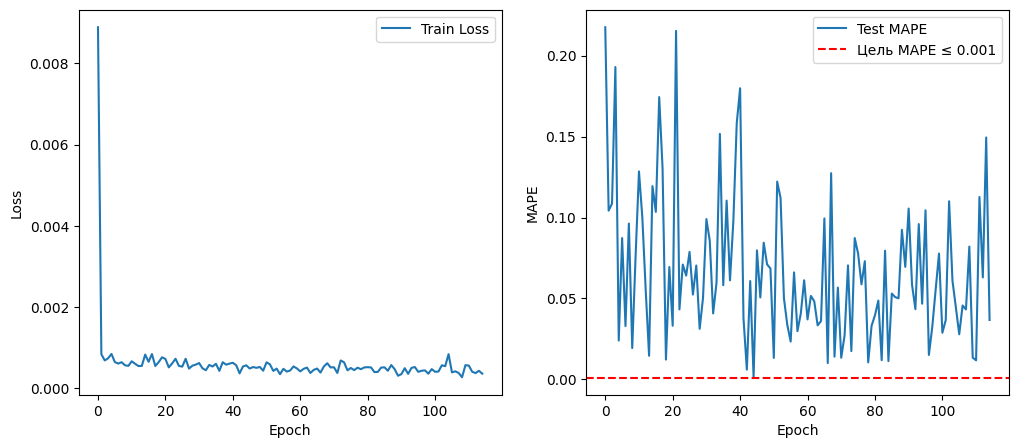

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Отключение недетерминированных алгоритмов
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),
            nn.BatchNorm1d(100),  # <- BatchNorm после Linear
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
#добавлн AdamW c L-2 регуляризацией
optimizer = optim.AdamW(model.parameters(),
                       lr=0.001,
                       weight_decay=0.001)

criterion = nn.MSELoss()

# Улучшенная логика ранней остановки
best_mape = float('inf')
early_stop_patience = 70
patience_counter = 0
target_mape = 0.001
reached_target = False

train_losses, test_mape = [], []

# ОБУЧЕНИЕ
for epoch in range(550):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Валидация
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        current_mape = torch.mean(torch.abs((y_test - test_pred) / y_test)).item()
        test_mape.append(current_mape)

        # Сохраняем лучшую модель
        if current_mape < best_mape:
            best_mape = current_mape
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Проверка достижения цели
        if current_mape <= target_mape:
            print(f"Достигнут целевой MAPE на эпохе {epoch}: {current_mape:.6f}")
            reached_target = True
            break

        # Проверка ранней остановки
        if patience_counter >= early_stop_patience:
            print(f"Ранняя остановка на эпохе {epoch}. Лучший MAPE: {best_mape:.6f}")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.6f}, Test MAPE = {current_mape:.6f}")

# ЗАГРУЗКА ЛУЧШЕЙ МОДЕЛИ
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    final_mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item()
    print(f"\nЛучший достигнутый MAPE: {best_mape:.6f}")
    print(f"Финальный MAPE на тесте: {final_mape:.6f}")

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_mape, label='Test MAPE')
plt.axhline(y=target_mape, color='r', linestyle='--', label=f'Цель MAPE ≤ {target_mape}')
plt.xlabel('Epoch'), plt.ylabel('MAPE'), plt.legend()
plt.show()

Финальный MAPE на тесте: **0.001352**

MAPE был достигнут подбором времени остановки и балансом между количеством эпох, батчей, lr и weight_decay

P.S. Очень долгим подбором.... :(
